### Split up / Format / Clean closures.JSON data
- Intersections:
    - rd1 'at' rd2
    - rd1 '/' rd2
    - rd1 'and' rd2
- Single Roads:
    - rd1 '- to' rd2
    - rd '(000 block) - to' rd2
    - rd '- from' rd1 'to' rd2
- Shared Roads:
    - name1 '/' name2
- Entire Roads:
    - rd
    
#### I WANT:
- DATAFRAME[type=road/intersection, road, from, to, original_text]

In [1]:
import json, re, pandas as pd, numpy as np

# read in closure data  --> make Closures.JSON READ ONLY******
with open ('closures.JSON') as json_file:
    closures_list = json.load(json_file)
json_file.close()

closures = np.array(closures_list)
print(closures[:10])

['13th at Dawson' '3rd St at Ann St' '3rd St at Dawson'
 '9th St (100 block) – to Chestnut St'
 'Airlie Rd (900 block) – to Bradley Creek Point Rd'
 'Alexander Rd -from McCormick Ln to Raintree Rd'
 'Allens Ln from Allens Ln to Cable Car Ln'
 'Arlington Dr at Castle Hayne Rd'
 'Asheton Rd – from Gordon Rd to Cantwell'
 'Athens Ln – from Green Meadows Dr to Edwards St']


In [2]:
# Create DataFrame to store our parsed street names
col_names = ['type', 'road', 'from', 'to', 'original_text']
closures_df = pd.DataFrame(columns=col_names)
entire_rd = []

# For each observation in closures data add info to DataFrame based on string structure
for c in closures:
    # Logic to break up intersection observations (rd1 at/ rd2)
    if (' at ' in c) or (' and ' in c) or (('/' in c) and (' to ' not in c)):
        c_splits = re.split(' at | and |/', c)
        df_entry = {'type': 'intersection', 'road': '', 'from': c_splits[0].strip(), 
                        'to': c_splits[-1].strip(), 'original_text': c}
        closures_df = closures_df.append(df_entry, ignore_index=True)
        
    # Logic for non-intersection streets (rd - from rd1 to rd2)   
    elif ('from' in c) or (' to ' in c):
        c_splits = re.split('–|-|from| to ', c)
        
        # Check to see if we have 3 usable splits, handle cases with only 2
        if (len(c_splits) == 2) or (c_splits[-2] == '') or (c_splits[-2] == ' '):
            df_entry = {'type': 'road', 'road': c_splits[0].strip(), 'from': c_splits[0].strip(), 
                        'to': c_splits[-1].strip(), 'original_text': c}
            closures_df = closures_df.append(df_entry, ignore_index=True)
        # If not then take 3 split up road names
        else:
            df_entry = {'type': 'road', 'road': c_splits[0].strip(), 'from': c_splits[-2].strip(), 
                        'to': c_splits[-1].strip(), 'original_text': c}
            closures_df = closures_df.append(df_entry, ignore_index=True)

    # Remaining observations should only contain 1 street name (I'm assuming the entire street was closed)
    else:
        df_entry = {'type': 'other', 'road': c, 'from': '', 'to': '', 'original_text': c}
        closures_df = closures_df.append(df_entry, ignore_index=True)
        

#### Still have some strange text present:
- '(X000 block)'
- 'name1 / name2'
- 'heading south'
- 'ramp/lanes closed'
- ...


In [3]:
closures_df.head(20)

,type,road,from,to,original_text
0,intersection,,13th,Dawson,13th at Dawson
1,intersection,,3rd St,Ann St,3rd St at Ann St
2,intersection,,3rd St,Dawson,3rd St at Dawson
3,road,9th St (100 block),9th St (100 block),Chestnut St,9th St (100 block) – to Chestnut St
4,road,Airlie Rd (900 block),Airlie Rd (900 block),Bradley Creek Point Rd,Airlie Rd (900 block) – to Bradley Creek Point Rd
5,road,Alexander Rd,McCormick Ln,Raintree Rd,Alexander Rd -from McCormick Ln to Raintree Rd
6,road,Allens Ln,Allens Ln,Cable Car Ln,Allens Ln from Allens Ln to Cable Car Ln
7,intersection,,Arlington Dr,Castle Hayne Rd,Arlington Dr at Castle Hayne Rd
8,road,Asheton Rd,Gordon Rd,Cantwell,Asheton Rd – from Gordon Rd to Cantwell
9,road,Athens Ln,Green Meadows Dr,Edwards St,Athens Ln – from Green Meadows Dr to Edwards St


### Following Example from GitHub repo
- https://github.com/gboeing/osmnx-examples/blob/master/notebooks/06-example-osmnx-networkx.ipynb

In [4]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, requests
%matplotlib inline
ox.config(log_file=True, log_console=True, use_cache=True)
ox.__version__

'0.8.2'

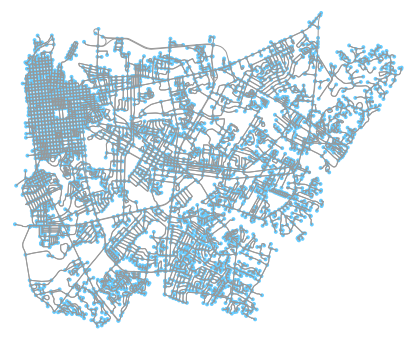

In [5]:
# get a graph for some city
G = ox.graph_from_place('Wilmington, North Carolina, USA', network_type='drive')
fig, ax = ox.plot_graph(G)

In [6]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

141601039.23942125

In [7]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

{'circuity_avg': 1.0666492666391827,
 'clean_intersection_count': 3211,
 'clean_intersection_density_km': 22.676387244381665,
 'edge_density_km': 13482.046242415705,
 'edge_length_avg': 153.9325720851474,
 'edge_length_total': 1909071.758999998,
 'intersection_count': 3613,
 'intersection_density_km': 25.515349459343184,
 'k_avg': 5.197820620284996,
 'm': 12402,
 'n': 4772,
 'node_density_km': 33.70031763630935,
 'self_loop_proportion': 0.010482180293501049,
 'street_density_km': 7286.681782436745,
 'street_length_avg': 156.07347042807467,
 'street_length_total': 1031801.7130000016,
 'street_segments_count': 6611,
 'streets_per_node_avg': 2.7558675607711653,
 'streets_per_node_counts': {0: 0, 1: 1159, 2: 16, 3: 2448, 4: 1129, 5: 20},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.24287510477787091,
  2: 0.003352891869237217,
  3: 0.5129924559932942,
  4: 0.23658843252305115,
  5: 0.004191114836546521}}

In [8]:
# Look into what the node values are
origin_node = list(G.nodes())[0]
destination_node = list(G.nodes())[-1]

origin_node

172556289

In [9]:
test = list(G.edges(data=True))
for t in test:
    #print(t[2]['name'])
    if not t[2]['name']:
        continue
    else:
        print(t[2]['name'])

Pepys Lane
Pepys Lane
Pepys Lane
Peachtree Avenue
South 42nd Street
South 42nd Street
Peachtree Avenue
Riegel Road
Price Drive
Riegel Road
Peachtree Avenue
South 44th Street
Peachtree Avenue
Wrightsville Avenue
Softwind Way
Wrightsville Avenue
Peachtree Avenue
Peachtree Avenue
South 45th Street


KeyError: 'name'

In [10]:
test[0][2]['name']

'Pepys Lane'

In [15]:
G.edges(data=True)

OutMultiEdgeDataView([(172556289, 172508973, {'osmid': 16690557, 'name': 'Pepys Lane', 'highway': 'residential', 'oneway': False, 'length': 75.101, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000259609BDA20>}), (172556289, 5685436493, {'osmid': 596988788, 'name': 'Pepys Lane', 'highway': 'residential', 'oneway': False, 'length': 151.93, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000259609BDD30>}), (172556289, 5685436493, {'osmid': [596988788, 596989117], 'highway': 'residential', 'oneway': False, 'length': 359.14599999999996, 'name': 'Pepys Lane', 'geometry': <shapely.geometry.linestring.LineString object at 0x000002596D236A58>}), (172539906, 172539903, {'osmid': 16689382, 'name': 'Peachtree Avenue', 'highway': 'residential', 'oneway': False, 'length': 97.035}), (172539906, 172545013, {'osmid': 16689736, 'name': 'South 42nd Street', 'highway': 'residential', 'oneway': False, 'length': 203.622}), (172539906, 172545010, {'osmid': 16689736, 'na

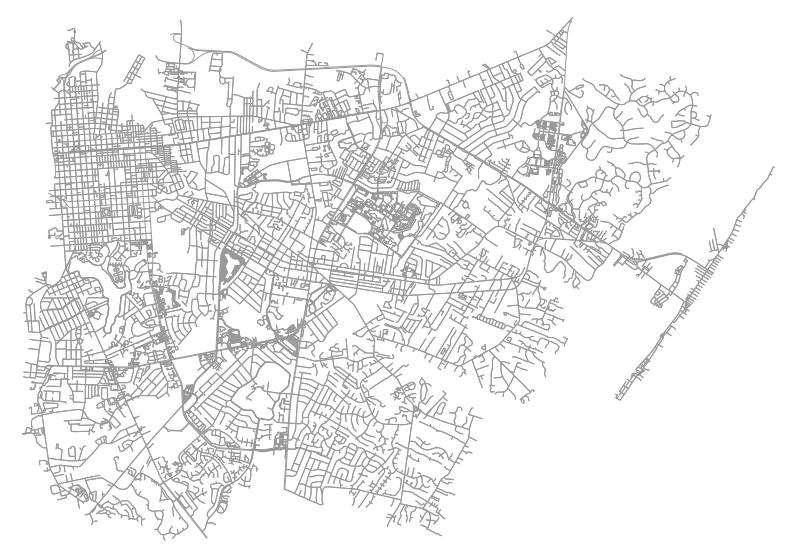

In [9]:
#### FROM Notebook 01-osmnx-overview ####

# you can also pass multiple places as a mixed list of strings and/or structured queries
places = ['Wrightsville Beach, North Carolina, USA',
          {'city':'Wilmington', 'state':'North Carolina'},     #Different way to structure location
          'Carolina Beach, North Carolina']                    #I don't think it got CB
G5 = ox.graph_from_place(places, clean_periphery=False)
G5_projected = ox.project_graph(G5)
fig, ax = ox.plot_graph(G5_projected, fig_height=10, node_size=0)
ox.save_graph_shapefile(G5, filename='false')